<a href="https://colab.research.google.com/github/suneel87/Deep-Fake-Image-Detection/blob/main/DeepFake_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install streamlit

### **Import Necessary Modules**

In [3]:
from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm


%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models
import streamlit as st

### **Functions Used**

In [4]:
'''
This functions computes the Contrastive loss for a CFFN

Input: Label(y)(0 or 1), Feature Vectors for a pair of images(fx1,fx2)
Output: The value of Contrastive loss
Return Type: PyTorch Tensor
'''
def ContrastiveLoss(y,fx1,fx2):
  m=2
  E=torch.pow((fx1-fx2),2)
  mat_max = np.maximum(np.zeros((y.shape[0], 128)), torch.pow((m-E),2).detach().cpu().numpy())
  torch_loss = 0.5*(y.detach().cpu().numpy()*torch.pow(E,2).detach().cpu().numpy().T) + (1-y.detach().cpu().numpy())*mat_max.T
  return torch.tensor(torch.sum(torch.tensor(torch_loss.T)), requires_grad=True)

In [5]:
'''
This functions plots multiple images in one grid

Input: A grid of images made using torch.utils
Output: The plot (matplotlib) for these images in one grid
'''
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [6]:
'''
This functions plots the loss for that particular iteration in an epoch

Input: Iteration Number (iteration) and the Loss (loss)
Output: The matplotlib plot for the loss
'''
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [7]:
'''
This functions predicts the state of a given image

Input: The image (image)
Output: The value of the state of the image (0 for fake and 1 for real)
Return Type: Integer
'''
def predict_image(image):

    net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
    net2 = NeuralNet().cuda()

    net.load_state_dict(torch.load("net.pth"))
    net2.load_state_dict(torch.load("net2.pth"))

    net.eval()
    net2.eval()
    test_transforms = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    img=Image.open(image)
    image_tensor = test_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.cuda()
    out1=net([input])
    output = net2(out1[0])
    print(output.data.cpu().numpy())
    index = output.data.cpu().numpy().argmax()
    
    return index

### **Reading the images and pairing them**

In [8]:
fake = glob("/content/drive/My Drive/faces/fake/*")
real = glob("/content/drive/My Drive/faces/real/*")

In [9]:
fake_ = [x.split("/")[-1] for x in fake]
real_ = [x.split("/")[-1] for x in real]

fake_ = ["fake_" + x for x in fake_]

In [10]:
start = time.time()

pairs_distinct = list(product(real_,fake_))

pairs_real = list(product(real_,real_))

pairs_fake = list(product(fake_,fake_))

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:00.325161


In [11]:
len(pairs_distinct) + len(pairs_fake) + len(pairs_real)

3127921

In [12]:
pairs = pairs_distinct + pairs_real + pairs_fake
pairs = sample(pairs, len(pairs))
pairs = list(set(pairs))

In [13]:
ord('f'), ord('r')

(102, 114)

In [14]:
start = time.time()

label_dict = {}
for idx, pair in enumerate(pairs):
    l1, l2 = pair[0].split("_")[0][0], pair[1].split("_")[0][0]
    
    l_sum = ord(l1) + ord(l2)
    
    if l_sum == 204:
        label = 1 #impostor pair
    elif l_sum == 216:
        label = 0
    elif l_sum == 228:
        label = 1 # real pair
    
    label_dict[idx] = label

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:04.738180


### **Forming a Dataset**

In [15]:
BATCH_SIZE=64
NUMBER_EPOCHS=30
IMG_SIZE=100

In [25]:
import sklearn.model_selection
import pandas as pd

In [22]:
train_per = .70
test_per = .15
val_per = .15
total_len = len(pairs)

a, b = sklearn.model_selection.train_test_split(pairs, train_size=train_per, test_size=test_per + val_per)
b, c = sklearn.model_selection.train_test_split(b, train_size=test_per, test_size=val_per)

In [23]:
len(a), len(b), len(c)

(2189544, 140756, 140757)

In [24]:
class DFDataset(Dataset):
    
    def __init__(self, root_dir, real_dir, fake_dir, pairs, lab_dict, transform=None):
        self.root_dir = root_dir
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.pairs = pairs
        self.lab_dict = lab_dict
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        class_labels = []
        
        if pair[0].split("_")[0] == "real":
            img1 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[0]}')
            class_labels.append(1)
            
        elif pair[0].split("_")[0] == "fake":
            path_ = pair[0].replace('fake_', '')
            img1 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if pair[1].split("_")[0] == "real":
            img2 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[1]}')
            class_labels.append(1)
            
        elif pair[1].split("_")[0] == "fake":
            path_ = pair[1].replace('fake_', '')
            img2 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        
        label = self.lab_dict[idx]
        
        return img1, img2, label, class_labels
        

In [28]:
trainset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(a), 10000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


valset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(c), 10000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

valloader = DataLoader(valset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


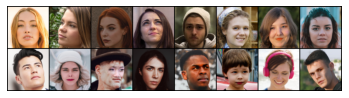

[0 1 0 0 1 1 1 1]


In [29]:
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### **Building a CFFN**

In [30]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network
    def __init__(self,model,n):#Parameters: The name of the model used and the size
        super(SiameseNetwork, self).__init__()
        self.cnn1 = model
        self.fc1 = nn.Linear(n, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)


    def forward(self, inputs):
        results = []

        for input in inputs:
            output = self.cnn1(input)
            output = output.view(output.size()[0], -1)
            output = F.relu(self.fc1(output))
            output = F.relu(self.fc2(output))
            output = self.fc3(output)

            results.append(output)

        return results

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch： 0  start.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Iteration number 0
 Current loss 10763.30292489061

Iteration number 1
 Current loss 10817.965701628222

Iteration number 2
 Current loss 9845.70352918332

Iteration number 3
 Current loss 10815.340527074859

Iteration number 4
 Current loss 7826.620910024467

Iteration number 5
 Current loss 11288.630229389762

Iteration number 6
 Current loss 7826.118715631546

Iteration number 7
 Current loss 11294.886084135795

Iteration number 8
 Current loss 10304.138259998579

Iteration number 9
 Current loss 10294.140155989404

Iteration number 10
 Current loss 7863.421855864679

Iteration number 11
 Current loss 9320.353789046914

Iteration number 12
 Current loss 8857.968091544268

Iteration number 13
 Current loss 12237.551519543704

Iteration number 14
 Current loss 12733.27420898917

Iteration number 15
 Current loss 8351.580653036714

Iteration number 16
 Current loss 9763.007687396102

Iteration number 17
 Current loss 10286.775882000944

Iteration number 18
 Current loss 9278.8958467986

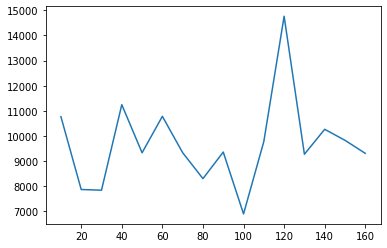

Epoch： 1  start.
Iteration number 0
 Current loss 10778.367226504113

Iteration number 1
 Current loss 10326.879238504018

Iteration number 2
 Current loss 11792.13365938308

Iteration number 3
 Current loss 7860.784545220768

Iteration number 4
 Current loss 13263.97763779047

Iteration number 5
 Current loss 10803.327732810383

Iteration number 6
 Current loss 8324.699599371525

Iteration number 7
 Current loss 9832.073322737171

Iteration number 8
 Current loss 7843.9773355173675

Iteration number 9
 Current loss 10779.798997232887

Iteration number 10
 Current loss 8361.772983862136

Iteration number 11
 Current loss 9811.963204780566

Iteration number 12
 Current loss 10814.654411093908

Iteration number 13
 Current loss 10795.907019377082

Iteration number 14
 Current loss 8373.601501164585

Iteration number 15
 Current loss 9773.613955400928

Iteration number 16
 Current loss 9795.159780041713

Iteration number 17
 Current loss 9834.35644698413

Iteration number 18
 Current loss

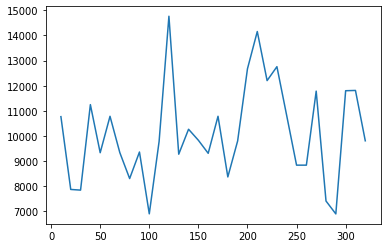

Epoch： 2  start.
Iteration number 0
 Current loss 10764.53670648283

Iteration number 1
 Current loss 10846.598049288597

Iteration number 2
 Current loss 9336.339705469352

Iteration number 3
 Current loss 12287.562639857748

Iteration number 4
 Current loss 12237.4118092465

Iteration number 5
 Current loss 14687.163696435862

Iteration number 6
 Current loss 11743.773932996039

Iteration number 7
 Current loss 10306.359610145468

Iteration number 8
 Current loss 11753.932860238405

Iteration number 9
 Current loss 11225.289021695524

Iteration number 10
 Current loss 7874.3769816939375

Iteration number 11
 Current loss 10690.840162225468

Iteration number 12
 Current loss 11266.926738083612

Iteration number 13
 Current loss 9800.176141057125

Iteration number 14
 Current loss 8808.728378847785

Iteration number 15
 Current loss 9322.833732511615

Iteration number 16
 Current loss 6406.744586003648

Iteration number 17
 Current loss 13227.917718463881

Iteration number 18
 Current 

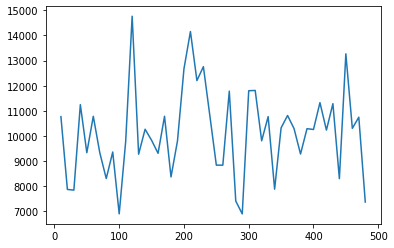

Epoch： 3  start.
Iteration number 0
 Current loss 10803.429566573835

Iteration number 1
 Current loss 14194.301586869082

Iteration number 2
 Current loss 12311.962924813546

Iteration number 3
 Current loss 11789.910676936197

Iteration number 4
 Current loss 10810.58151709066

Iteration number 5
 Current loss 13680.5055709192

Iteration number 6
 Current loss 9787.947950012544

Iteration number 7
 Current loss 8346.116494773007

Iteration number 8
 Current loss 10276.115680643228

Iteration number 9
 Current loss 10698.007878364482

Iteration number 10
 Current loss 8845.845605058652

Iteration number 11
 Current loss 11794.379100075193

Iteration number 12
 Current loss 11287.754772636701

Iteration number 13
 Current loss 7802.19408777539

Iteration number 14
 Current loss 7848.001257143608

Iteration number 15
 Current loss 12735.893658200284

Iteration number 16
 Current loss 12744.628257252854

Iteration number 17
 Current loss 8897.6811255674

Iteration number 18
 Current loss

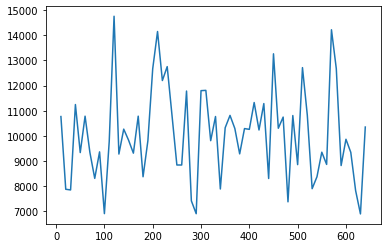

Epoch： 4  start.
Iteration number 0
 Current loss 14195.36786232307

Iteration number 1
 Current loss 9807.81990172937

Iteration number 2
 Current loss 11247.06857403434

Iteration number 3
 Current loss 10257.854790428351

Iteration number 4
 Current loss 7327.434153569595

Iteration number 5
 Current loss 11228.417680539445

Iteration number 6
 Current loss 7893.483163947643

Iteration number 7
 Current loss 9266.622773144778

Iteration number 8
 Current loss 12718.752783488975

Iteration number 9
 Current loss 8787.815378279847

Iteration number 10
 Current loss 13214.675165946472

Iteration number 11
 Current loss 14188.353489040192

Iteration number 12
 Current loss 10294.775291944727

Iteration number 13
 Current loss 10344.939955478254

Iteration number 14
 Current loss 11747.114577788767

Iteration number 15
 Current loss 10786.335520519342

Iteration number 16
 Current loss 9784.316097137817

Iteration number 17
 Current loss 10277.258276936416

Iteration number 18
 Current l

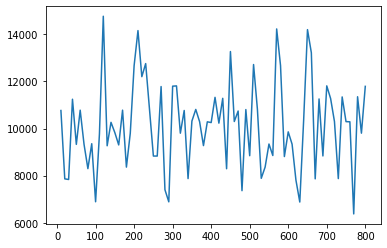

Epoch： 5  start.
Iteration number 0
 Current loss 7849.022495915646

Iteration number 1
 Current loss 11222.313072361227

Iteration number 2
 Current loss 6838.130093653375

Iteration number 3
 Current loss 10748.889583607623

Iteration number 4
 Current loss 6869.333099919975

Iteration number 5
 Current loss 11249.473329141878

Iteration number 6
 Current loss 12725.860602391102

Iteration number 7
 Current loss 8752.617883765046

Iteration number 8
 Current loss 9818.078166422853

Iteration number 9
 Current loss 10775.679820731075

Iteration number 10
 Current loss 8344.339437310606

Iteration number 11
 Current loss 8810.057025396543

Iteration number 12
 Current loss 10796.368190323794

Iteration number 13
 Current loss 10740.581914726241

Iteration number 14
 Current loss 10262.081463770446

Iteration number 15
 Current loss 11764.756868007376

Iteration number 16
 Current loss 11315.934249013837

Iteration number 17
 Current loss 11262.814556775451

Iteration number 18
 Current

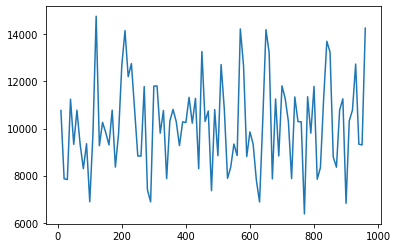

Epoch： 6  start.
Iteration number 0
 Current loss 12223.400785354595

Iteration number 1
 Current loss 10764.48049260729

Iteration number 2
 Current loss 8821.509609472268

Iteration number 3
 Current loss 10301.153574778134

Iteration number 4
 Current loss 7379.574252905745

Iteration number 5
 Current loss 11265.486868757496

Iteration number 6
 Current loss 11278.46996495843

Iteration number 7
 Current loss 8852.174660379009

Iteration number 8
 Current loss 10764.203233557415

Iteration number 9
 Current loss 9781.43572184983

Iteration number 10
 Current loss 11274.700511455489

Iteration number 11
 Current loss 6396.524699616067

Iteration number 12
 Current loss 8808.0123546781

Iteration number 13
 Current loss 7854.141089944382

Iteration number 14
 Current loss 9330.472157398788

Iteration number 15
 Current loss 7855.595796858381

Iteration number 16
 Current loss 7360.762599738267

Iteration number 17
 Current loss 7861.828228916312

Iteration number 18
 Current loss 987

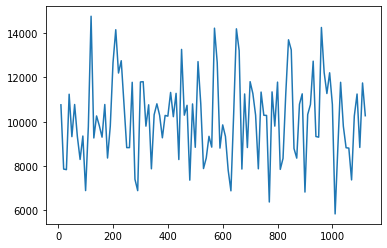

Epoch： 7  start.
Iteration number 0
 Current loss 10319.39514061088

Iteration number 1
 Current loss 11691.235854425093

Iteration number 2
 Current loss 7876.2209139226325

Iteration number 3
 Current loss 5911.990489068334

Iteration number 4
 Current loss 9242.377376546036

Iteration number 5
 Current loss 10274.432817391425

Iteration number 6
 Current loss 11301.903425247068

Iteration number 7
 Current loss 9247.685977835768

Iteration number 8
 Current loss 9279.688056168477

Iteration number 9
 Current loss 9321.930155518083

Iteration number 10
 Current loss 10314.948768215972

Iteration number 11
 Current loss 9335.367690546844

Iteration number 12
 Current loss 9856.934709709487

Iteration number 13
 Current loss 9812.9484611094

Iteration number 14
 Current loss 10293.598277099454

Iteration number 15
 Current loss 10764.573433589814

Iteration number 16
 Current loss 10277.583672528646

Iteration number 17
 Current loss 9780.148220989391

Iteration number 18
 Current loss

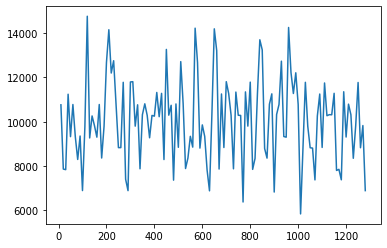

Epoch： 8  start.
Iteration number 0
 Current loss 12233.940764204073

Iteration number 1
 Current loss 10793.129184667685

Iteration number 2
 Current loss 7811.724677274451

Iteration number 3
 Current loss 6411.786576743917

Iteration number 4
 Current loss 10744.013693488123

Iteration number 5
 Current loss 11833.260039986591

Iteration number 6
 Current loss 12226.587389334372

Iteration number 7
 Current loss 9356.2855199415

Iteration number 8
 Current loss 8777.219791571884

Iteration number 9
 Current loss 14175.95306384061

Iteration number 10
 Current loss 9305.223034179176

Iteration number 11
 Current loss 9280.472499375046

Iteration number 12
 Current loss 10298.888474352421

Iteration number 13
 Current loss 8850.818193617248

Iteration number 14
 Current loss 7845.070191670277

Iteration number 15
 Current loss 10758.852313530602

Iteration number 16
 Current loss 10337.12337868751

Iteration number 17
 Current loss 11746.05167505569

Iteration number 18
 Current loss 

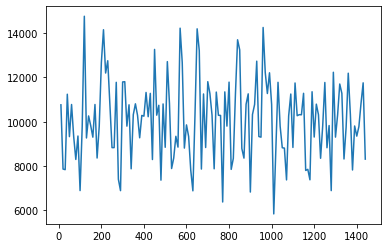

Epoch： 9  start.
Iteration number 0
 Current loss 9321.931213618867

Iteration number 1
 Current loss 5951.71927025574

Iteration number 2
 Current loss 12227.536036759295

Iteration number 3
 Current loss 8784.468573769202

Iteration number 4
 Current loss 7836.64105376888

Iteration number 5
 Current loss 7388.830161634276

Iteration number 6
 Current loss 10339.896735864755

Iteration number 7
 Current loss 12265.330440390606

Iteration number 8
 Current loss 11784.840127987763

Iteration number 9
 Current loss 8828.697394524905

Iteration number 10
 Current loss 10236.361737075982

Iteration number 11
 Current loss 9314.816320454687

Iteration number 12
 Current loss 11772.300322281728

Iteration number 13
 Current loss 10750.47563992184

Iteration number 14
 Current loss 8862.408440766918

Iteration number 15
 Current loss 8852.114313459479

Iteration number 16
 Current loss 10294.332856401179

Iteration number 17
 Current loss 8307.745292545886

Iteration number 18
 Current loss 

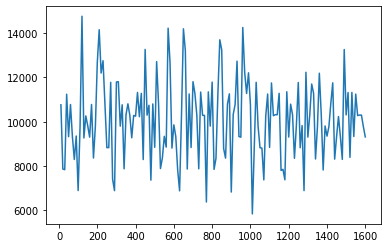

Epoch： 10  start.
Iteration number 0
 Current loss 11220.096704530019

Iteration number 1
 Current loss 9299.205599756719

Iteration number 2
 Current loss 9802.563477893094

Iteration number 3
 Current loss 8294.280627938744

Iteration number 4
 Current loss 10283.606621312476

Iteration number 5
 Current loss 10294.053762869313

Iteration number 6
 Current loss 11822.310340020345

Iteration number 7
 Current loss 9300.56560624063

Iteration number 8
 Current loss 12726.918047715091

Iteration number 9
 Current loss 11298.337495735275

Iteration number 10
 Current loss 11793.164072364427

Iteration number 11
 Current loss 10311.80317698469

Iteration number 12
 Current loss 10832.012405124902

Iteration number 13
 Current loss 9847.676174525246

Iteration number 14
 Current loss 6846.593736456642

Iteration number 15
 Current loss 5372.502901792067

Iteration number 16
 Current loss 8352.42350873526

Iteration number 17
 Current loss 9350.289232125207

Iteration number 18
 Current los

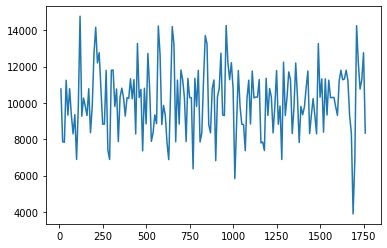

Epoch： 11  start.
Iteration number 0
 Current loss 8331.494642007687

Iteration number 1
 Current loss 7804.2858030548305

Iteration number 2
 Current loss 8851.8051228415

Iteration number 3
 Current loss 8807.66519461165

Iteration number 4
 Current loss 12275.45249037651

Iteration number 5
 Current loss 10794.041891344039

Iteration number 6
 Current loss 5868.48193257724

Iteration number 7
 Current loss 9320.207403797289

Iteration number 8
 Current loss 10320.4870767934

Iteration number 9
 Current loss 11770.825300537412

Iteration number 10
 Current loss 15657.132043957425

Iteration number 11
 Current loss 11265.864449962952

Iteration number 12
 Current loss 9763.861181401902

Iteration number 13
 Current loss 7340.256655219846

Iteration number 14
 Current loss 9278.8275179967

Iteration number 15
 Current loss 12699.834665652143

Iteration number 16
 Current loss 10815.561528532338

Iteration number 17
 Current loss 11306.308590884048

Iteration number 18
 Current loss 785

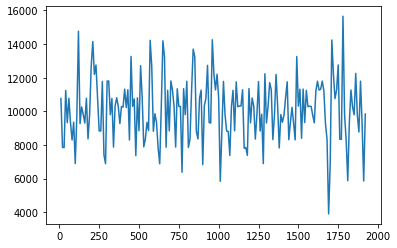

Epoch： 12  start.
Iteration number 0
 Current loss 10822.866304019351

Iteration number 1
 Current loss 12765.873063533341

Iteration number 2
 Current loss 12311.046093662886

Iteration number 3
 Current loss 11293.585114040028

Iteration number 4
 Current loss 11270.640211691856

Iteration number 5
 Current loss 9813.11128898224

Iteration number 6
 Current loss 10753.583894324905

Iteration number 7
 Current loss 10822.340990916462

Iteration number 8
 Current loss 12774.828945945112

Iteration number 9
 Current loss 8259.119406072768

Iteration number 10
 Current loss 7849.245337750486

Iteration number 11
 Current loss 11731.994350205285

Iteration number 12
 Current loss 11717.19584832182

Iteration number 13
 Current loss 10307.529262155087

Iteration number 14
 Current loss 8351.219180223643

Iteration number 15
 Current loss 9285.632188708903

Iteration number 16
 Current loss 10334.176807141193

Iteration number 17
 Current loss 9793.929398141545

Iteration number 18
 Current

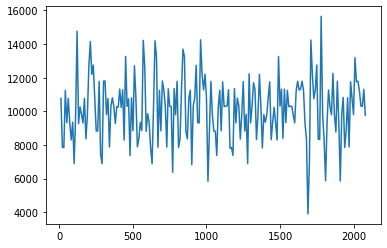

Epoch： 13  start.
Iteration number 0
 Current loss 12750.454627201192

Iteration number 1
 Current loss 8309.13148987975

Iteration number 2
 Current loss 10796.001277821875

Iteration number 3
 Current loss 11265.717322581755

Iteration number 4
 Current loss 12236.651337263418

Iteration number 5
 Current loss 7875.5814899966235

Iteration number 6
 Current loss 10290.51681119962

Iteration number 7
 Current loss 10789.006248320879

Iteration number 8
 Current loss 8810.108421230163

Iteration number 9
 Current loss 8360.893299630276

Iteration number 10
 Current loss 10295.98558180632

Iteration number 11
 Current loss 8886.510767866957

Iteration number 12
 Current loss 7890.921264176929

Iteration number 13
 Current loss 6886.859353657117

Iteration number 14
 Current loss 12666.944415023716

Iteration number 15
 Current loss 11259.97348588834

Iteration number 16
 Current loss 10270.529422281372

Iteration number 17
 Current loss 10239.3291207386

Iteration number 18
 Current los

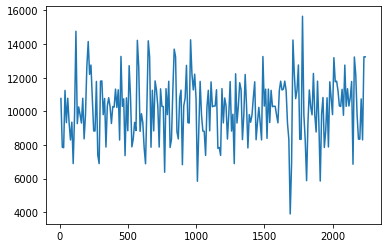

Epoch： 14  start.
Iteration number 0
 Current loss 9804.490460391153

Iteration number 1
 Current loss 10279.986482126624

Iteration number 2
 Current loss 8827.558020989476

Iteration number 3
 Current loss 9338.082036595448

Iteration number 4
 Current loss 12716.90466677305

Iteration number 5
 Current loss 7868.012031285894

Iteration number 6
 Current loss 9314.030968527697

Iteration number 7
 Current loss 14193.80074046274

Iteration number 8
 Current loss 8789.25686932855

Iteration number 9
 Current loss 11316.952655393616

Iteration number 10
 Current loss 12267.656012216548

Iteration number 11
 Current loss 14239.869201228857

Iteration number 12
 Current loss 10705.76017829065

Iteration number 13
 Current loss 8299.074208296377

Iteration number 14
 Current loss 9318.589585959291

Iteration number 15
 Current loss 9361.91792134702

Iteration number 16
 Current loss 9825.429428805883

Iteration number 17
 Current loss 15624.041678003276

Iteration number 18
 Current loss 9

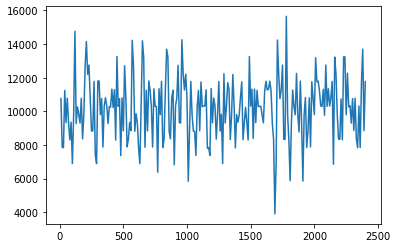

Epoch： 15  start.
Iteration number 0
 Current loss 13269.265670213917

Iteration number 1
 Current loss 7345.805769808565

Iteration number 2
 Current loss 10240.759448188877

Iteration number 3
 Current loss 7847.568153339816

Iteration number 4
 Current loss 11288.269298991305

Iteration number 5
 Current loss 9769.680923844591

Iteration number 6
 Current loss 4930.511798451444

Iteration number 7
 Current loss 10285.090082425242

Iteration number 8
 Current loss 9791.208948267085

Iteration number 9
 Current loss 9325.835578111524

Iteration number 10
 Current loss 11270.465147371582

Iteration number 11
 Current loss 10286.662343915725

Iteration number 12
 Current loss 10295.397093012714

Iteration number 13
 Current loss 10777.724850477074

Iteration number 14
 Current loss 6899.389841412872

Iteration number 15
 Current loss 9321.810959904753

Iteration number 16
 Current loss 11239.35827267629

Iteration number 17
 Current loss 12248.93458640594

Iteration number 18
 Current l

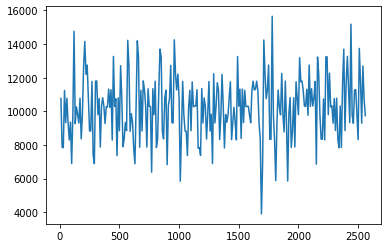

Epoch： 16  start.
Iteration number 0
 Current loss 11730.629450623046

Iteration number 1
 Current loss 11307.22498759897

Iteration number 2
 Current loss 11720.64947371386

Iteration number 3
 Current loss 11799.527305982978

Iteration number 4
 Current loss 10315.029400694822

Iteration number 5
 Current loss 5366.312287034931

Iteration number 6
 Current loss 12729.212462478643

Iteration number 7
 Current loss 10789.047984840188

Iteration number 8
 Current loss 12230.290156675852

Iteration number 9
 Current loss 11281.74896072784

Iteration number 10
 Current loss 9337.86777482595

Iteration number 11
 Current loss 8290.334541153958

Iteration number 12
 Current loss 10289.917368758726

Iteration number 13
 Current loss 9810.51134153292

Iteration number 14
 Current loss 9811.507206679691

Iteration number 15
 Current loss 9789.021629718434

Iteration number 16
 Current loss 13215.922906932814

Iteration number 17
 Current loss 12722.568622800194

Iteration number 18
 Current lo

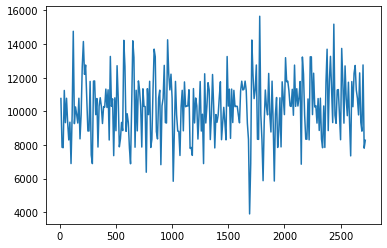

Epoch： 17  start.
Iteration number 0
 Current loss 11803.167681718018

Iteration number 1
 Current loss 10300.675029381466

Iteration number 2
 Current loss 7856.739229808325

Iteration number 3
 Current loss 11281.912672143939

Iteration number 4
 Current loss 10722.766768110814

Iteration number 5
 Current loss 10278.542560616208

Iteration number 6
 Current loss 7873.600370658058

Iteration number 7
 Current loss 8825.68365751061

Iteration number 8
 Current loss 7347.229945232375

Iteration number 9
 Current loss 8852.106906405797

Iteration number 10
 Current loss 7814.22876641993

Iteration number 11
 Current loss 8325.303034697105

Iteration number 12
 Current loss 8328.34855964297

Iteration number 13
 Current loss 7843.574859434061

Iteration number 14
 Current loss 10808.953354917157

Iteration number 15
 Current loss 10758.038296286131

Iteration number 16
 Current loss 9778.060847753959

Iteration number 17
 Current loss 9825.229794867693

Iteration number 18
 Current loss 

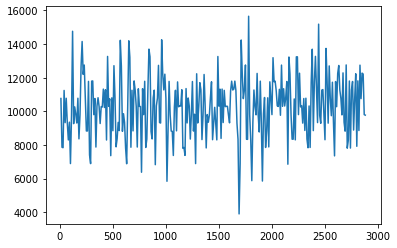

Epoch： 18  start.
Iteration number 0
 Current loss 10788.613280645124

Iteration number 1
 Current loss 10265.608699839511

Iteration number 2
 Current loss 11282.017169481305

Iteration number 3
 Current loss 12288.100859665823

Iteration number 4
 Current loss 9779.151794622923

Iteration number 5
 Current loss 9309.935766402668

Iteration number 6
 Current loss 10316.022000961262

Iteration number 7
 Current loss 8381.634396946629

Iteration number 8
 Current loss 6394.567397264665

Iteration number 9
 Current loss 13717.19840230167

Iteration number 10
 Current loss 9822.075366759058

Iteration number 11
 Current loss 8369.353257651084

Iteration number 12
 Current loss 9300.933089783224

Iteration number 13
 Current loss 11247.209919267807

Iteration number 14
 Current loss 12231.489463377147

Iteration number 15
 Current loss 7355.379772113576

Iteration number 16
 Current loss 8819.288046068616

Iteration number 17
 Current loss 10302.03448954396

Iteration number 18
 Current lo

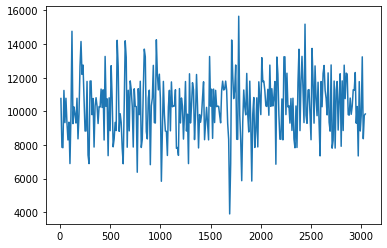

Epoch： 19  start.
Iteration number 0
 Current loss 13254.239661341842

Iteration number 1
 Current loss 6905.461085961677

Iteration number 2
 Current loss 11736.298275820971

Iteration number 3
 Current loss 10825.729753483934

Iteration number 4
 Current loss 9795.679321642598

Iteration number 5
 Current loss 9302.120613243453

Iteration number 6
 Current loss 11285.904707496338

Iteration number 7
 Current loss 11271.001785789173

Iteration number 8
 Current loss 12230.869616627437

Iteration number 9
 Current loss 9801.655567536

Iteration number 10
 Current loss 9304.74120131266

Iteration number 11
 Current loss 11704.420669742673

Iteration number 12
 Current loss 9318.350004886815

Iteration number 13
 Current loss 9304.714423723251

Iteration number 14
 Current loss 9837.443346278373

Iteration number 15
 Current loss 10776.734664264484

Iteration number 16
 Current loss 9842.255366727575

Iteration number 17
 Current loss 10750.003388985453

Iteration number 18
 Current loss

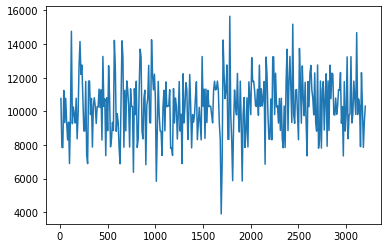

Epoch： 20  start.
Iteration number 0
 Current loss 7849.770347053396

Iteration number 1
 Current loss 11210.806905368852

Iteration number 2
 Current loss 13660.469614054828

Iteration number 3
 Current loss 9311.867866848264

Iteration number 4
 Current loss 10811.146800278944

Iteration number 5
 Current loss 8835.869254669418

Iteration number 6
 Current loss 9807.025787782655

Iteration number 7
 Current loss 8281.580676265054

Iteration number 8
 Current loss 9376.355795226118

Iteration number 9
 Current loss 8890.801651638816

Iteration number 10
 Current loss 10754.577863998495

Iteration number 11
 Current loss 12680.950839711075

Iteration number 12
 Current loss 11793.442735653098

Iteration number 13
 Current loss 8343.213460240251

Iteration number 14
 Current loss 10752.177053650312

Iteration number 15
 Current loss 10781.879206133815

Iteration number 16
 Current loss 8845.271879720827

Iteration number 17
 Current loss 7844.515135349838

Iteration number 18
 Current l

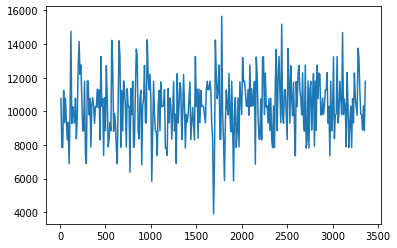

Epoch： 21  start.
Iteration number 0
 Current loss 15238.622341126349

Iteration number 1
 Current loss 11318.729546936944

Iteration number 2
 Current loss 14236.7390884568

Iteration number 3
 Current loss 6367.327846723079

Iteration number 4
 Current loss 11278.32668050894

Iteration number 5
 Current loss 8340.133881625505

Iteration number 6
 Current loss 9814.30720305687

Iteration number 7
 Current loss 10271.70189952774

Iteration number 8
 Current loss 8287.846302680166

Iteration number 9
 Current loss 8812.173527992272

Iteration number 10
 Current loss 11278.644885183843

Iteration number 11
 Current loss 10804.065725769868

Iteration number 12
 Current loss 6357.445659276419

Iteration number 13
 Current loss 11759.60539358258

Iteration number 14
 Current loss 11333.61497779786

Iteration number 15
 Current loss 8884.490881237858

Iteration number 16
 Current loss 10282.587688076104

Iteration number 17
 Current loss 10280.719465257429

Iteration number 18
 Current loss 

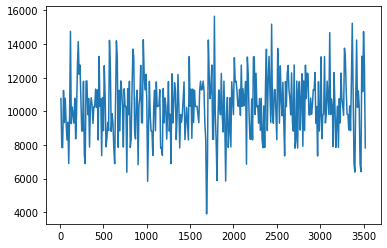

Epoch： 22  start.
Iteration number 0
 Current loss 10818.508594979943

Iteration number 1
 Current loss 9803.0235069559

Iteration number 2
 Current loss 9815.098526220545

Iteration number 3
 Current loss 10319.598690703951

Iteration number 4
 Current loss 13237.360296142424

Iteration number 5
 Current loss 10783.287121943933

Iteration number 6
 Current loss 9836.93597525822

Iteration number 7
 Current loss 6789.187767043401

Iteration number 8
 Current loss 9811.558362194213

Iteration number 9
 Current loss 8840.913115384175

Iteration number 10
 Current loss 10298.024143038112

Iteration number 11
 Current loss 12725.287295507305

Iteration number 12
 Current loss 6855.408708916286

Iteration number 13
 Current loss 9792.723655117448

Iteration number 14
 Current loss 11292.780253144078

Iteration number 15
 Current loss 9407.162808141225

Iteration number 16
 Current loss 6318.56232162567

Iteration number 17
 Current loss 9267.266791993101

Iteration number 18
 Current loss 8

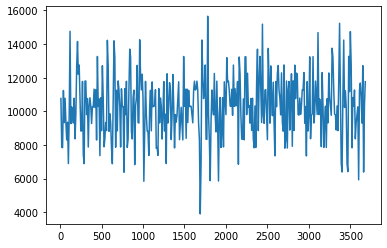

Epoch： 23  start.
Iteration number 0
 Current loss 10301.507942489083

Iteration number 1
 Current loss 12295.251947242672

Iteration number 2
 Current loss 8837.856301957388

Iteration number 3
 Current loss 14243.102159622

Iteration number 4
 Current loss 11322.218738146435

Iteration number 5
 Current loss 13217.899657123162

Iteration number 6
 Current loss 10800.84106319427

Iteration number 7
 Current loss 11725.217116742448

Iteration number 8
 Current loss 8783.683519587674

Iteration number 9
 Current loss 13276.656731877349

Iteration number 10
 Current loss 9307.141856672239

Iteration number 11
 Current loss 11778.797589577933

Iteration number 12
 Current loss 14224.421370912114

Iteration number 13
 Current loss 11732.670256028036

Iteration number 14
 Current loss 7880.548102605609

Iteration number 15
 Current loss 11283.808462036835

Iteration number 16
 Current loss 11294.295606517862

Iteration number 17
 Current loss 11785.873617527017

Iteration number 18
 Current

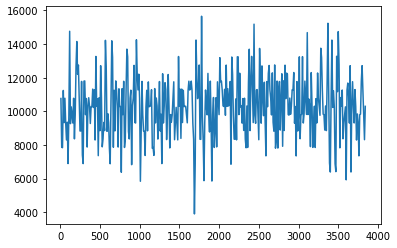

Epoch： 24  start.
Iteration number 0
 Current loss 12269.643344576562

Iteration number 1
 Current loss 10804.832719729462

Iteration number 2
 Current loss 10793.231824489167

Iteration number 3
 Current loss 11751.72316943563

Iteration number 4
 Current loss 9338.919427917997

Iteration number 5
 Current loss 12766.174985658647

Iteration number 6
 Current loss 8801.410122876456

Iteration number 7
 Current loss 12229.92127624599

Iteration number 8
 Current loss 12745.220804285182

Iteration number 9
 Current loss 5886.486780379618

Iteration number 10
 Current loss 8343.177163624272

Iteration number 11
 Current loss 11751.962940992227

Iteration number 12
 Current loss 11275.63031217318

Iteration number 13
 Current loss 8293.086050321652

Iteration number 14
 Current loss 11289.824098773888

Iteration number 15
 Current loss 5374.934066167004

Iteration number 16
 Current loss 12260.666404570991

Iteration number 17
 Current loss 12284.553652038667

Iteration number 18
 Current 

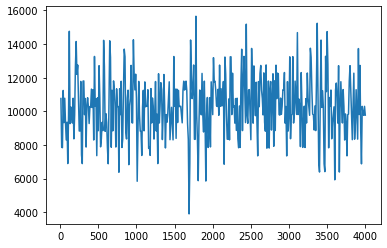

Epoch： 25  start.
Iteration number 0
 Current loss 9742.276583967056

Iteration number 1
 Current loss 11756.792401855522

Iteration number 2
 Current loss 10294.96857117211

Iteration number 3
 Current loss 10748.465531516125

Iteration number 4
 Current loss 13720.67809473629

Iteration number 5
 Current loss 8368.128823227804

Iteration number 6
 Current loss 9821.7335935541

Iteration number 7
 Current loss 10807.037816770786

Iteration number 8
 Current loss 11265.826908243394

Iteration number 9
 Current loss 11769.441303550917

Iteration number 10
 Current loss 9811.374253324328

Iteration number 11
 Current loss 10787.461318131303

Iteration number 12
 Current loss 5930.166387621215

Iteration number 13
 Current loss 9354.541813150798

Iteration number 14
 Current loss 8342.29930587711

Iteration number 15
 Current loss 7331.109072171324

Iteration number 16
 Current loss 10277.27601313881

Iteration number 17
 Current loss 8373.425512725202

Iteration number 18
 Current loss 7

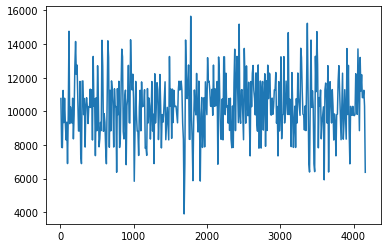

Epoch： 26  start.
Iteration number 0
 Current loss 8314.413571479845

Iteration number 1
 Current loss 9803.919757744034

Iteration number 2
 Current loss 13283.74201026255

Iteration number 3
 Current loss 6847.651417330204

Iteration number 4
 Current loss 13260.86134146176

Iteration number 5
 Current loss 7825.131968015305

Iteration number 6
 Current loss 11242.078473243253

Iteration number 7
 Current loss 12239.644365070544

Iteration number 8
 Current loss 13209.71866942137

Iteration number 9
 Current loss 11302.052590110452

Iteration number 10
 Current loss 9280.070114666316

Iteration number 11
 Current loss 11271.787041246336

Iteration number 12
 Current loss 8339.292887493013

Iteration number 13
 Current loss 10254.83846330614

Iteration number 14
 Current loss 12731.860518171437

Iteration number 15
 Current loss 10287.231797347777

Iteration number 16
 Current loss 11298.779728615908

Iteration number 17
 Current loss 9314.311894104092

Iteration number 18
 Current lo

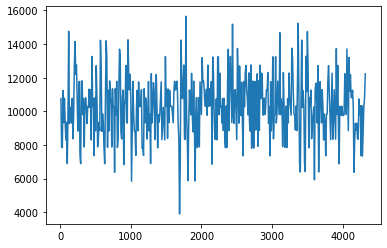

Epoch： 27  start.
Iteration number 0
 Current loss 11257.399053570723

Iteration number 1
 Current loss 9795.77391286999

Iteration number 2
 Current loss 11286.838801797669

Iteration number 3
 Current loss 9319.529457934012

Iteration number 4
 Current loss 10304.619154108033

Iteration number 5
 Current loss 9787.589539991222

Iteration number 6
 Current loss 11759.770456865172

Iteration number 7
 Current loss 10797.631725243276

Iteration number 8
 Current loss 11237.851967733155

Iteration number 9
 Current loss 9834.703306325628

Iteration number 10
 Current loss 10821.82941572654

Iteration number 11
 Current loss 12197.73372605345

Iteration number 12
 Current loss 10324.509161247599

Iteration number 13
 Current loss 12792.866598741719

Iteration number 14
 Current loss 10803.532520524746

Iteration number 15
 Current loss 11822.700717045866

Iteration number 16
 Current loss 9781.691458746542

Iteration number 17
 Current loss 8864.460933846593

Iteration number 18
 Current 

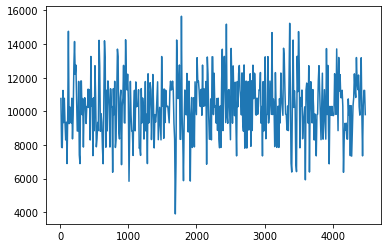

Epoch： 28  start.
Iteration number 0
 Current loss 13252.881578650435

Iteration number 1
 Current loss 9313.642259574248

Iteration number 2
 Current loss 9805.632538539538

Iteration number 3
 Current loss 12678.898655906882

Iteration number 4
 Current loss 9303.286786489403

Iteration number 5
 Current loss 9814.32647186158

Iteration number 6
 Current loss 14183.58747144338

Iteration number 7
 Current loss 10772.41848514526

Iteration number 8
 Current loss 11253.950787424292

Iteration number 9
 Current loss 8329.048237967789

Iteration number 10
 Current loss 11725.060542623378

Iteration number 11
 Current loss 7844.644948438983

Iteration number 12
 Current loss 14157.421696261848

Iteration number 13
 Current loss 10770.813500558608

Iteration number 14
 Current loss 11774.734847876578

Iteration number 15
 Current loss 11699.831436631628

Iteration number 16
 Current loss 13193.174817377097

Iteration number 17
 Current loss 9801.073156324192

Iteration number 18
 Current l

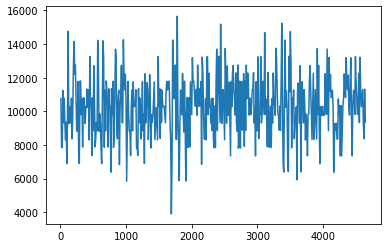

Epoch： 29  start.
Iteration number 0
 Current loss 10295.122936671165

Iteration number 1
 Current loss 10797.580965673375

Iteration number 2
 Current loss 11233.715848248325

Iteration number 3
 Current loss 14202.329270109529

Iteration number 4
 Current loss 10809.070152743207

Iteration number 5
 Current loss 11249.107187872358

Iteration number 6
 Current loss 10779.668897594722

Iteration number 7
 Current loss 8411.267593533774

Iteration number 8
 Current loss 9774.270207681755

Iteration number 9
 Current loss 12202.90019275862

Iteration number 10
 Current loss 11305.829519744417

Iteration number 11
 Current loss 10279.196032025859

Iteration number 12
 Current loss 8325.380408722765

Iteration number 13
 Current loss 11761.835137635391

Iteration number 14
 Current loss 10772.687751823021

Iteration number 15
 Current loss 10246.811287970073

Iteration number 16
 Current loss 10796.935387032247

Iteration number 17
 Current loss 11265.253853961442

Iteration number 18
 Cur

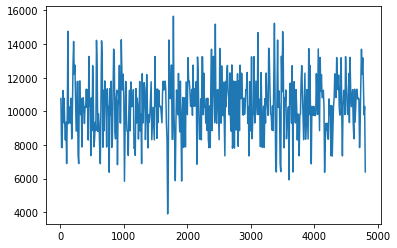

In [31]:
# custom_cnn =  nn.Sequential(
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(3, BATCH_SIZE, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(BATCH_SIZE),
#             nn.Dropout2d(p=.2),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(BATCH_SIZE, BATCH_SIZE, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(BATCH_SIZE),
#             nn.Dropout2d(p=.2),

#             nn.ReflectionPad2d(1),
#             nn.Conv2d(BATCH_SIZE, 32, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(p=.2),
#         )

# custom_cnn_n = 32*100*100

#models.resnet50(pretrained=True)

#models.alexnet(pretrained=True)

#models.densenet(pretrained=True)

#models.vgg16(pretrained=True)

#models.resnet50(pretrained=True)

#models.googlenet(pretrained=True)

net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, _ = data
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        loss = ContrastiveLoss(labels, outputs[0], outputs[1])
        loss.backward()
        optimizer.step()

        print("Iteration number {}\n Current loss {}\n".format(i,loss.item()))
        if i %10 == 0 :#show changes of loss value after each 10 batches
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing
        for data in valloader:
            img0, img1 , labels, _ = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net([img0,img1])
            _, predicted = torch.max(outputs[0].data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

### **Building a Classification Network**

In [32]:
class NeuralNet(nn.Module):
    
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=128,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84,  
                             out_features=2)
        self.activation = nn.Softmax(dim=1)

        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.activation(X)

In [ ]:
net2 = NeuralNet().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,5):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, class_labels = data 
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        out2 = net2(outputs[0])
        loss = criterion(out2, class_labels[0].cuda())

        loss.backward()
        optimizer.step()

        print("Iteration number {}\n Current loss {}\n".format(i,loss.item()))
        if i %10 == 0 :#show changes of loss value after each 10 batches
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing
        for data in valloader:
            img0, img1 , labels, class_labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net([img0,img1])
            out = net2(outputs[0])
            _, predicted = torch.max(out.data, 1)
            total_val += class_labels[0].cuda().size(0)
            correct_val += (predicted == class_labels[0].cuda()).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

Epoch： 0  start.
Iteration number 0
 Current loss 0.6926590800285339

Iteration number 1
 Current loss 0.6929457783699036

Iteration number 2
 Current loss 0.6924201846122742

Iteration number 3
 Current loss 0.6923823356628418

Iteration number 4
 Current loss 0.6926300525665283

Iteration number 5
 Current loss 0.6928725242614746

Iteration number 6
 Current loss 0.6925963163375854

Iteration number 7
 Current loss 0.6929397583007812

Iteration number 8
 Current loss 0.6924700140953064

Iteration number 9
 Current loss 0.6926077604293823

Iteration number 10
 Current loss 0.6927099823951721

Iteration number 11
 Current loss 0.6926326155662537

Iteration number 12
 Current loss 0.6927179098129272

Iteration number 13
 Current loss 0.6924678087234497

Iteration number 14
 Current loss 0.6931355595588684

Iteration number 15
 Current loss 0.692415714263916

Iteration number 16
 Current loss 0.6928896307945251

Iteration number 17
 Current loss 0.6925935745239258

Iteration number 18
 C

In [ ]:
torch.save(net.state_dict(),"resnet-cffn.pth")
torch.save(net2.state_dict(),"resnet-clf.pth")

### **Streamlit GUI**

In [ ]:
#Writing all necessary functions in one cell
%%writefile DeepFakeGUI.py
import streamlit as st

from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models


class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self,model,n):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = model
        self.fc1 = nn.Linear(n, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)


    def forward(self, inputs):#did not know how to let two resnet share the same param.
        results = []

        for input in inputs:
            output = self.cnn1(input)
            output = output.view(output.size()[0], -1)
            output = F.relu(self.fc1(output))
            output = F.relu(self.fc2(output))
            output = self.fc3(output)

            results.append(output)

        return results


class NeuralNet(nn.Module):
    
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=128,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84,  
                             out_features=2)
        self.activation = nn.Softmax(dim=1)

        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.activation(X)


st.title("Deepfake Detection App")
st.subheader("This app takes in an image uploaded by the user and upon clicking the 'Verdict' button, displays if the uploaded image is fake or real" )

uploaded_file = st.file_uploader("Choose an image from your file directory", type=["jpg","png","jpeg"])
if uploaded_file is not None:
    image = Image.open(uploaded_file)

    net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
    net2 = NeuralNet().cuda()

    net.load_state_dict(torch.load("net.pth"))
    net2.load_state_dict(torch.load("net2.pth"))

    net.eval()
    net2.eval()

    st.image(image, caption='Uploaded Image.', use_column_width= True)
    st.write("")
    test_transforms = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.cuda()
    out1=net([input])
    output = net2(out1[0])
    print(output.data.cpu().numpy())
    prediction = output.data.cpu().numpy().argmax()

    if(st.button('Verdict')):
        if prediction == 0:
            st.error("The image uploaded is fake")
        elif prediction == 1:
            st.success("The image uploaded is real")

Overwriting DeepFakeGUI.py


In [ ]:
#Command to run the GUI
!streamlit run DeepFakeGUI.py & npx localtunnel --port 8501

npx: installed 22 in 1.418s
your url is: https://tender-turtle-63.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.234.14.117:8501

[[0.5 0.5]]
[[0.5 0.5]]
  Stopping...
^C
